In [1]:
from src.ds.causal_graph import CausalGraph
import torch as T
from src.scm.ncm import VAE
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from src.scm.prior.realnvp import FlowPrior

cg_graph = "CDML_cg"
cg_file = "{}.cg" .format(cg_graph)
cg = CausalGraph.read(cg_file)
device = T.device("cuda" if T.cuda.is_available() else "cpu")

batch_size = 100
input_size = 1
seq_length = 20
latent_dim = 50
#prior = FlowPrior(3, latent_dim * seq_length, 250)
prior = T.nn.ModuleDict({i: FlowPrior(1, latent_dim, 250) for i in ["X1", "X2", "Y1"]})
#orig_input = T.load('matrix_test.pth')
#orig_input = orig_input.astype(np.float32)
model = VAE(latent_dim, cg, input_size, seq_length, batch_size, prior, device)
model.load_state_dict(T.load('model_weights/CDML/model_weights_9.pth', map_location=T.device('cpu')))

C:\Users\luiso\AppData\Local\Temp\ipykernel_28144\1256076993.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(T.load('model_weights/CDML/model_weig

<All keys matched successfully>

In [2]:
with open('CDML_dataset_3_variables.pkl', 'rb') as file:
    CDML_dfs = pickle.load(file)

CDML_dfs = [df.astype(np.float32).reset_index(drop=True) for df in CDML_dfs]

In [93]:
with open("CDML_dataset_3_variables_27_01_2025.pkl", "rb") as file:
    CDML_dfs_new = pickle.load(file)

CDML_dfs_new = [df.astype(np.float32).reset_index(drop=True) for df in CDML_dfs_new]

In [107]:
n_samples = 10000
ran_samp = model.sample(n_samples, 20)

In [195]:
ran_samp.keys()

dict_keys(['X1', 'X2', 'Y1'])

### Histogram of all points in real distribution and our model's distribution

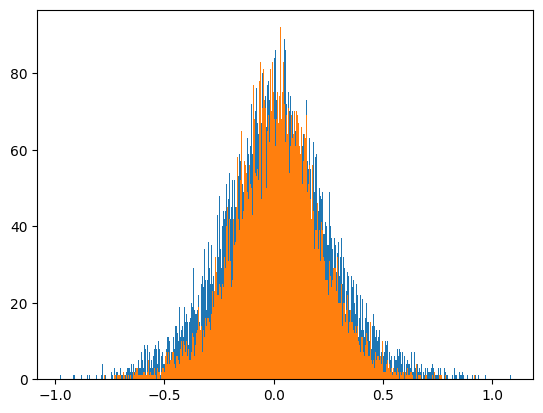

In [198]:
f_val_ori = [i["Y1"].iloc[1] for i in CDML_dfs]

f_val_sam = ran_samp["Y1"][:,1,0].detach().numpy()

plt.hist(f_val_ori, bins=500)
plt.hist(f_val_sam, bins=500)
plt.show()

### KL Divergence real distribution and our model's distribution

In [222]:
from scipy.stats import entropy

bins = 1000

temp_1 = 0
temp_2 = 0

for idx in range(20):
    f_val_ori = [i["Y1"].iloc[idx] for i in CDML_dfs]
    f_val_sam = ran_samp["Y1"][:,idx,0].detach().numpy()

    p_hist, _ = np.histogram(f_val_ori, bins=bins, density=True)
    q_hist, _ = np.histogram(f_val_sam, bins=bins, density=True)

    # Add a small constant to avoid division by zero and log(0)
    epsilon = 1e-10
    p_hist += epsilon
    q_hist += epsilon

    # Normalize histograms to ensure they sum to 1
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)

    # Compute KL divergence
    kl_div_pq = entropy(p_hist, q_hist)  # D_KL(P || Q)
    kl_div_qp = entropy(q_hist, p_hist)  # D_KL(Q || P)

    temp_1 += kl_div_pq

In [223]:
temp_1/20

np.float64(0.2963429323968792)

The optimal weights are loaded.
The model was trained for 1000 epochs.

With learning rate
lr=0.0002
With betas
beta_1=0.5
beta_2=0.9

The counterfactual probability of given $.099 < X1_{t-2} <= .1$ that $Y > 0$

Histogram of marginal distribution $Y_{t+13}$ in real distribution and our model's distribution

[]

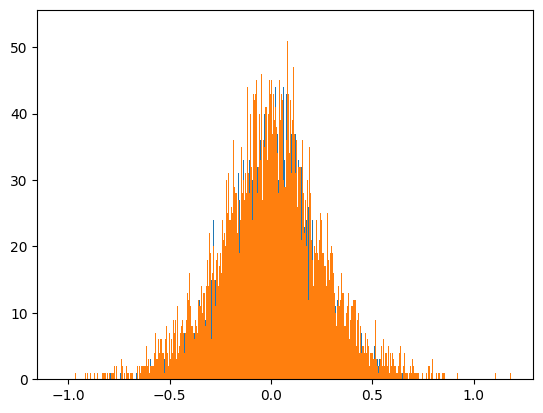

In [34]:
plt.hist(ran_samp["Y1"][:, 13].detach().numpy(), bins=1000)
plt.hist([i["Y1"].iloc[13].astype(np.float32) for i in CDML_dfs], bins=1000)
plt.plot()

As it can be seen the counterfactual probability inferred by the model falls in between the bounds.

In [132]:
def theory_bounds(marg_X1, marg_Y1, thres_x, thres_y):
    #left bound

    eps = .01
    p_x = np.sum([1 for x in marg_X1 if np.abs(x - thres_x) >= eps])/len(marg_X1)
    p_x_ctf = 1 - p_x

    p_y_and_x_ctf = np.sum([1 for x_1, y_1 in zip(marg_X1, marg_Y1) if np.abs(x_1 - thres_x) < eps and (y_1 > thres_y)])/len(marg_X1)
    p_y_given_x_ctf = p_y_and_x_ctf/p_x_ctf

    p_y_and_x = np.sum([1 for x_1, y_1 in zip(marg_X1, marg_Y1) if np.abs(x_1 - thres_x) >= eps and (y_1 > thres_y)])/len(marg_X1)
    p_y_given_x = p_y_and_x/p_x
    p_l = p_y_given_x_ctf/p_y_given_x

    p_y_ctf_and_x_ctf = np.sum([1 for x_1, y_1 in zip(marg_X1, marg_Y1) if (np.abs(x_1 - thres_x) < eps) and (y_1 < thres_y)])/len(marg_X1)
    p_y_ctf_given_x_ctf = p_y_ctf_and_x_ctf/p_x_ctf
    
    p_r = p_y_ctf_given_x_ctf/p_y_given_x
    l_b = max(0, 1 - p_l)

    #right bound
    r_b = min(1, p_r)

    return l_b, r_b

Theoretical bounds

In [180]:
#thres_x = -.2
#thres_y = .5
thres_x = .1
thres_y = 0

marg_X1 = [[i["X1"].iloc[date+1].astype(np.float32) for i in CDML_dfs_new] for date in range(CDML_dfs_new[0].shape[0]-3)]
marg_Y1 = [[i["Y1"].iloc[date+2+1].astype(np.float32) for i in CDML_dfs_new] for date in range(CDML_dfs_new[0].shape[0]-3)]

l = []
r = []

for i in range(len(marg_X1)):
    temp = theory_bounds(marg_X1[i], marg_Y1[i], thres_x, thres_y)
    l.append(temp[0])
    r.append(temp[1])


Counterfactual probability using do intervention

In [3]:
def ctf_prob(prior_path, inter_idx, thres_x, thres_y):
    
    n_samples = 10000
    n_path = 20

    # do interventions
    do_int = {"X1": {inter_idx: thres_x}}

    ctf_dic = model.ctf_decoder(prior_path, n_path, n_samples, do_int)

    var = "Y1"
    var_sam = ctf_dic[var]
    var_sam = var_sam.detach().numpy()

    ctf_sam_paths = var_sam[:, inter_idx+2]
    ctf_sam = np.sum((ctf_sam_paths < thres_y))/n_samples
    
    return ctf_sam

In [186]:
# prior path idx
thres_y = 0
pr_p_idx = 1
#thres_x = -.2
#thres_y = .5
#prior_path = CDML_dfs[0].iloc[:prior_path_idx]

ctf_prob_vals = [[ctf_prob(None, i, thres_x, thres_y) for i in range(pr_p_idx, CDML_dfs[0].shape[0]-2)] for _ in range(6)]

Ground truth

In [187]:
# ground truth
g_t_list = []
eps = .01
#thres_x = -.2
#thres_y = .5
#thres_x = .1
#thres_y = 0
pr_p_idx = 1

for idx in range(pr_p_idx, CDML_dfs[0].shape[0]-2):
    marg_X1 = [i["X1"].iloc[idx].astype(np.float32) for i in CDML_dfs_new]
    marg_Y1 = [i["Y1"].iloc[idx+2].astype(np.float32) for i in CDML_dfs_new]

    joint_Y_X1 = np.sum([1 for x_1, y_1 in zip(marg_X1, marg_Y1) if np.abs(x_1 - thres_x) < eps and (y_1 < thres_y)])/len(marg_X1)
    cond_X = np.sum([1 for x_1 in marg_X1 if np.abs(x_1 - thres_x) < eps])/len(marg_X1)

    g_t_prob = joint_Y_X1/cond_X
    g_t_list.append(g_t_prob)

Montecarlo sampling counterfactual computation

In [204]:
from copy import deepcopy
list_samples = []
pr_p_idx = 1
eps = .01
#thres_x = -.2
#thres_y = .5

for n_trys in range(6):
    list_trys = []
    for idx in range(pr_p_idx, CDML_dfs[0].shape[0]-2):
        ran_samp = model.sample(n_samples, 20)
        vec_X1_t_2 = ran_samp["X1"][:,idx,0].detach().numpy()
        vec_Y1_t_0 = ran_samp["Y1"][:,idx+2,0].detach().numpy()

        cond_X = np.sum([1 for i in vec_X1_t_2 if np.abs(i - thres_x) < eps])/len(vec_X1_t_2)
        joint_X_Y = np.sum([1 for x, y in zip(vec_X1_t_2, vec_Y1_t_0) if (np.abs(x - thres_x) < eps) and (y < thres_y)])/len(vec_Y1_t_0)
        ctf_sam = joint_X_Y/cond_X

        list_trys.append(ctf_sam)

    temp = deepcopy(list_trys)
    list_samples.append(temp)



Plot of montecarlo sampling counterfactual experiment

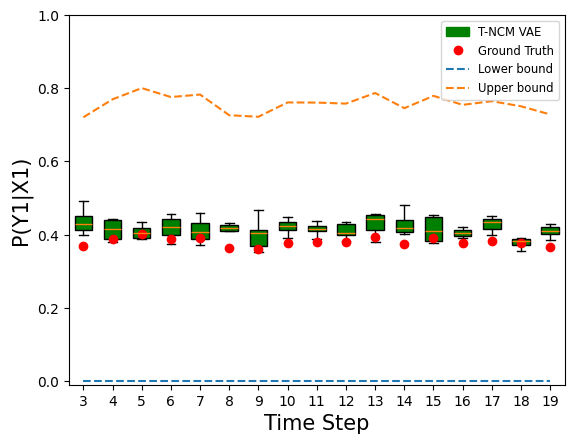

In [210]:
from matplotlib.patches import Patch
temp = list(zip(*list_samples))

fig, ax = plt.subplots()
len_dat = len(temp)
# Plot each box plot separately
positions = np.arange(1+2, len_dat+1+2)
capprops = dict(color='blue', linewidth=2)

low_b, = plt.plot(positions,l,linestyle="--",label='Lower bound')
up_b, = plt.plot(positions,r,linestyle="--",label='Upper bound')

plt.ylim(-.01, 1)
for i in range(len_dat):
    bp = ax.boxplot(temp[i], positions=[positions[i]], widths=0.6, showfliers=False, patch_artist=True)

    for box in bp['boxes']:
        box.set_facecolor('green')

ground_truth, = plt.plot(positions,g_t_list, marker='o', linestyle='', color='red', label="Ground Truth")
# Customize the plot
ax.set_ylabel('P(Y1|X1)', fontsize=15)
ax.set_xlabel('Time Step', fontsize=15)
# Set the x-axis labels
ax.set_xticks(positions)
boxplot_patch = Patch(color='green', label='T-NCM VAE')
plt.legend(handles=[boxplot_patch, ground_truth, low_b, up_b], labels=['T-NCM VAE', 'Ground Truth', 'Lower bound', 'Upper bound'], loc='upper right', fontsize='small')
plt.show()

Plot of do intervention counterfactual experiment

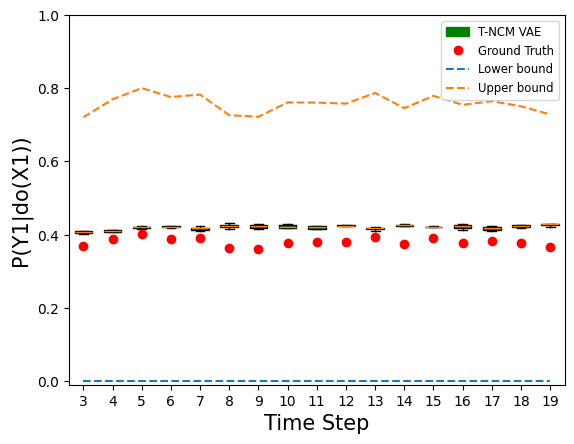

In [203]:
from matplotlib.patches import Patch
temp = list(zip(*ctf_prob_vals))

fig, ax = plt.subplots()
len_dat = len(temp)
# Plot each box plot separately
positions = np.arange(1+2, len_dat+1+2)
capprops = dict(color='blue', linewidth=2)

low_b, = plt.plot(positions,l,linestyle="--",label='Lower bound')
up_b, = plt.plot(positions,r,linestyle="--",label='Upper bound')

plt.ylim(-.01, 1)
for i in range(len_dat):
    bp = ax.boxplot(temp[i], positions=[positions[i]], widths=0.6, showfliers=False, patch_artist=True)

    for box in bp['boxes']:
        box.set_facecolor('green')

ground_truth, = plt.plot(positions,g_t_list, marker='o', linestyle='', color='red', label="Ground Truth")
# Customize the plot
ax.set_ylabel('P(Y1|do(X1))', fontsize=15)
ax.set_xlabel('Time Step', fontsize=15)
# Set the x-axis labels
ax.set_xticks(positions)
boxplot_patch = Patch(color='green', label='T-NCM VAE')
#plt.legend()
plt.legend(handles=[boxplot_patch, ground_truth, low_b, up_b], labels=['T-NCM VAE', 'Ground Truth', 'Lower bound', 'Upper bound'], loc='upper right', fontsize='small')
# Show the plot
plt.show()